In [1]:
import os
import sys
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

os.chdir(r"C:\Users\PC\Desktop\fraud_eye")  # Ana proje dizinine geç
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join('..', 'src')))  # src klasörünü ekle

from src.utils.visualizations import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_feature_importance,
    plot_threshold_optimization,
    plot_metrics_with_confusion_matrix,
    plot_models_comparison_dashboard,
    save_figure  # Artık görselleri kaydetmek için bu fonksiyonu kullanacağız
)

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

# Proje dizinini doğru şekilde belirle
from pathlib import Path

# Proje kök dizinini bul (fraud_eye)
def find_project_root():
    """Proje kök dizinini (fraud_eye) bulur"""
    possible_roots = [
        Path.cwd(),                      # Mevcut çalışma dizini
        Path.cwd().parent,               # Bir üst dizin
        Path.home() / 'Desktop' / 'fraud_eye',  # Masaüstündeki fraud_eye
        Path('C:/Users/PC/Desktop/fraud_eye')   # Belirli bir yol
    ]
    
    # Proje kökünü doğrulamak için beklenen klasörler
    expected_dirs = ['data', 'models', 'src', 'notebooks']
    
    for root in possible_roots:
        # En az 2 beklenen klasörün varlığını kontrol et
        if sum(1 for dir_name in expected_dirs if (root / dir_name).exists()) >= 2:
            print(f"✓ Proje kökü bulundu: {root}")
            return root
    
    # Varsayılan olarak mevcut dizini kullan ve uyarı ver
    print("⚠ Proje kökü bulunamadı! Mevcut dizin kullanılıyor.")
    return Path.cwd()

# Proje kökünü bul
PROJECT_ROOT = find_project_root()

# Proje sabitleri - artık PROJECT_ROOT'a göre tanımlanıyor
MODELS_DIR = PROJECT_ROOT / 'models'
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
REPORTS_DIR = PROJECT_ROOT / 'reports'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR / 'metrics', exist_ok=True)  # metrics klasörünü oluştur

# Versiyon etiketi - model güncellemelerinde bunu değiştirin
VERSION = "V1"

print(f"📁 Proje dizinleri:")
print(f"  - Proje kökü: {PROJECT_ROOT}")
print(f"  - Modeller: {MODELS_DIR}")
print(f"  - Veriler: {DATA_DIR}")
print(f"  - Raporlar: {REPORTS_DIR}")


✓ Proje kökü bulundu: C:\Users\PC\Desktop\fraud_eye
📁 Proje dizinleri:
  - Proje kökü: C:\Users\PC\Desktop\fraud_eye
  - Modeller: C:\Users\PC\Desktop\fraud_eye\models
  - Veriler: C:\Users\PC\Desktop\fraud_eye\data\processed
  - Raporlar: C:\Users\PC\Desktop\fraud_eye\reports


In [2]:
def load_models_and_data():
    """Modelleri ve veriyi yükler"""
    import os
    
    # Dosya isimleri
    model_files = {
        'xgb': 'xgboost_model.pkl',
        'lr': 'logistic_regression_model.pkl',
        'test_data': 'processed_test.csv'
    }
    
    # Dosya yolları
    file_paths = {
        'xgb': MODELS_DIR / model_files['xgb'],
        'lr': MODELS_DIR / model_files['lr'],
        'test_data': DATA_DIR / model_files['test_data']
    }
    
    # Dosyaların varlığını kontrol et
    missing = []
    for file_type, path in file_paths.items():
        if not path.exists():
            missing.append(f"{file_type}: {path}")
    
    if missing:
        error_msg = "\n".join(missing)
        raise FileNotFoundError(f"❌ Eksik dosyalar:\n{error_msg}\n"
                              f"Lütfen dosyaların doğru konumlarda olduğundan emin olun.")
    
    # Yükleme işlemleri
    try:
        xgb_model = joblib.load(file_paths['xgb'])
        lr_model = joblib.load(file_paths['lr'])
        test_df = pd.read_csv(file_paths['test_data'])
        
        print("\n✔ Tüm dosyalar başarıyla yüklendi!")
        print(f"XGBoost model tipi: {type(xgb_model)}")
        print(f"Logistic Regression model tipi: {type(lr_model)}")
        print(f"Test verisi boyutu: {test_df.shape}")
        
        return xgb_model, lr_model, test_df.drop(columns=['Class']), test_df['Class']
    
    except Exception as e:
        raise RuntimeError(f"Yükleme hatası: {str(e)}")

# Çalıştır
try:
    xgb_model, lr_model, X_test, y_test = load_models_and_data()
except Exception as e:
    print(e)
    print("\n💡 İPUCU: Dosyaların doğru konumda olduğunu kontrol edin:")
    print("""
    fraud-detection/
    ├── models/
    │   ├── xgboost_model.pkl
    │   └── logistic_regression_model.pkl
    ├── data/
    │   └── processed/
    │       └── processed_test.csv
    """)


✔ Tüm dosyalar başarıyla yüklendi!
XGBoost model tipi: <class 'src.models.xgboost.XGBoostModel'>
Logistic Regression model tipi: <class 'src.models.logistic_regression.LogisticRegressionModel'>
Test verisi boyutu: (56962, 41)


2025-05-16 02:28:09,378 | INFO | xgboost.py:77 | Making probability predictions on 56962 samples


📊 XGBoost Performans Metrikleri
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.88      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9828
Average Precision: 0.8737
✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\xgboost_confusion.png


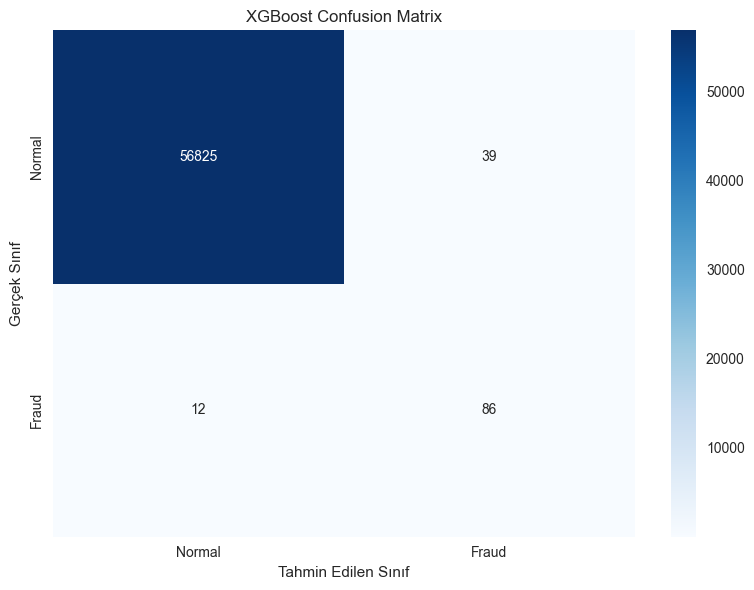

✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\xgboost_roc.png


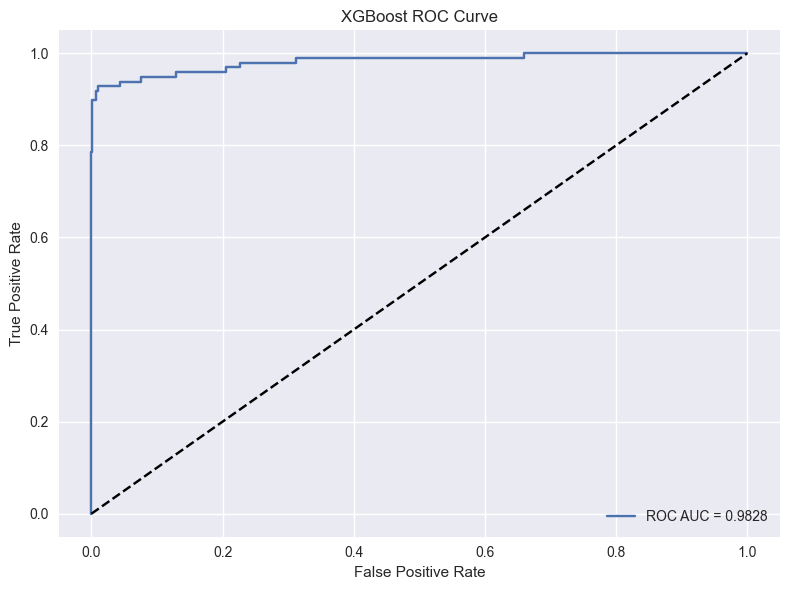

✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\xgboost_pr.png


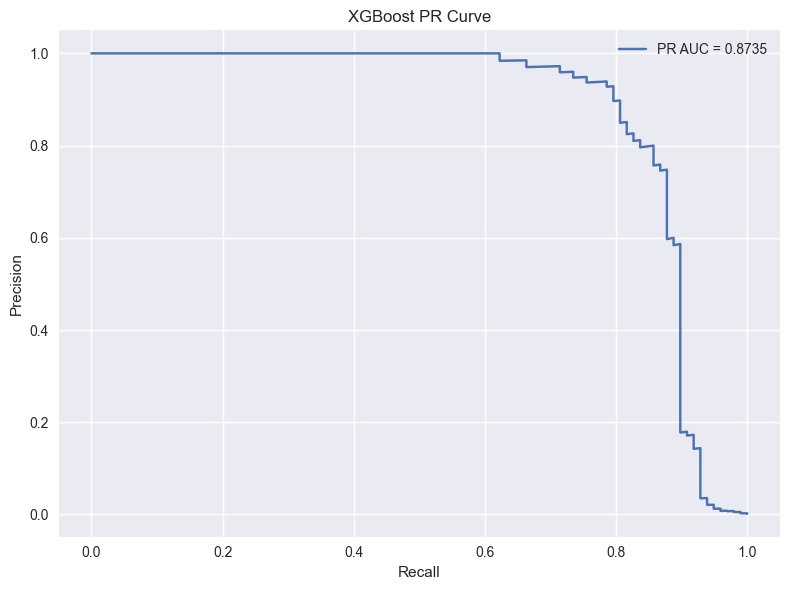

⚠ XGBoost modelinde feature_importances_ özelliği yok


In [3]:
# XGBoost için tahminler
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability estimates
xgb_preds = (xgb_probs >= 0.5).astype(int)  # Binary predictions

# Metrikler
print("📊 XGBoost Performans Metrikleri")
print("--------------------------------")
print(classification_report(y_test, xgb_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, xgb_probs):.4f}")
print(f"Average Precision: {average_precision_score(y_test, xgb_probs):.4f}")

# Görselleştirmeler - artık visualizations.py'deki save_figure fonksiyonunu kullanıyoruz
# Confusion Matrix
fig_cm = plot_confusion_matrix(y_test, xgb_preds, title='XGBoost Confusion Matrix')
save_figure(fig_cm, 'xgboost_confusion.png', version=VERSION, reports_dir=REPORTS_DIR)

# ROC Curve
fig_roc, _ = plot_roc_curve(y_test, xgb_probs, title='XGBoost ROC Curve')
save_figure(fig_roc, 'xgboost_roc.png', version=VERSION, reports_dir=REPORTS_DIR)

# Precision-Recall Curve
fig_pr, _ = plot_precision_recall_curve(y_test, xgb_probs, title='XGBoost PR Curve')
save_figure(fig_pr, 'xgboost_pr.png', version=VERSION, reports_dir=REPORTS_DIR)

# Feature Importance (sadece varsa)
if hasattr(xgb_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': xgb_model.feature_importances_
    })
    fig_imp = plot_feature_importance(importance_df, title='XGBoost Feature Importance')
    save_figure(fig_imp, 'xgboost_importance.png', version=VERSION, reports_dir=REPORTS_DIR)
else:
    print("⚠ XGBoost modelinde feature_importances_ özelliği yok")



2025-05-16 02:28:10,718 | INFO | logistic_regression.py:55 | Making probability predictions on 56962 samples


📊 Logistic Regression Performans Metrikleri
------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC Score: 0.9710
Average Precision: 0.7249
✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\logistic_confusion.png


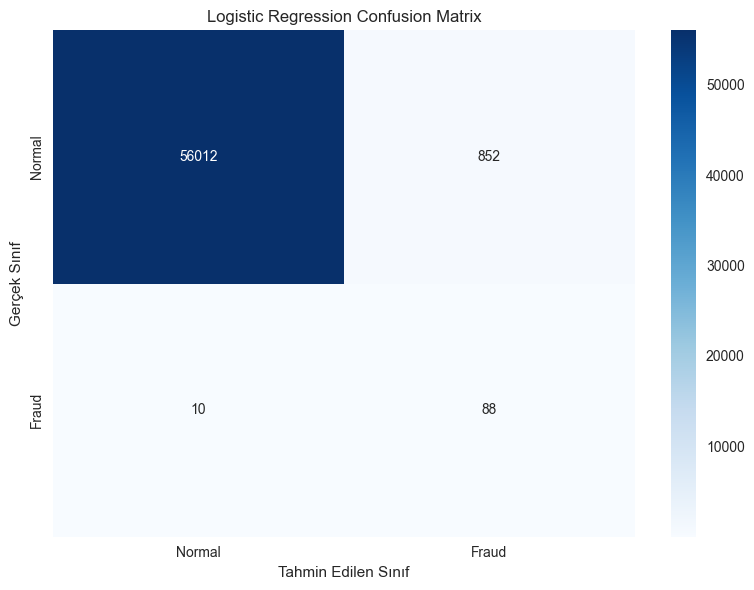

✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\logistic_roc.png


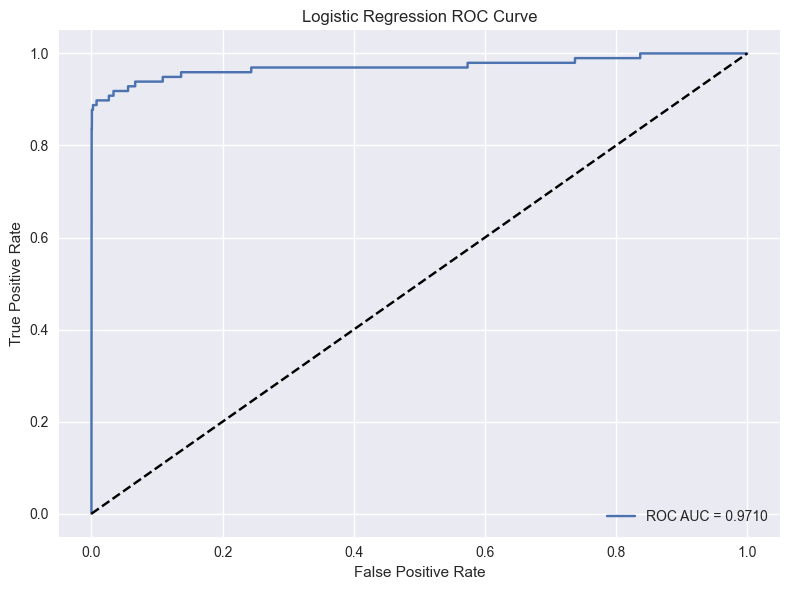

✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\logistic_pr.png


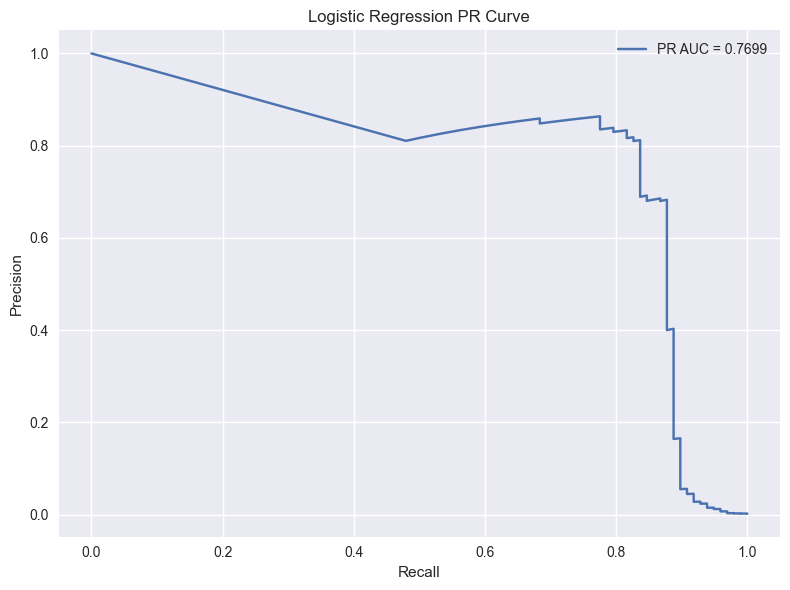

In [4]:
# Logistic Regression için tahminler
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_preds = (lr_probs >= 0.5).astype(int)

# Metrikler
print("📊 Logistic Regression Performans Metrikleri")
print("------------------------------------------")
print(classification_report(y_test, lr_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_probs):.4f}")
print(f"Average Precision: {average_precision_score(y_test, lr_probs):.4f}")

# Görselleştirmeler - Versiyonlu kaydetme
fig_cm = plot_confusion_matrix(y_test, lr_preds, title='Logistic Regression Confusion Matrix')
save_figure(fig_cm, 'logistic_confusion.png', version=VERSION, reports_dir=REPORTS_DIR)

fig_roc, _ = plot_roc_curve(y_test, lr_probs, title='Logistic Regression ROC Curve')
save_figure(fig_roc, 'logistic_roc.png', version=VERSION, reports_dir=REPORTS_DIR)

fig_pr, _ = plot_precision_recall_curve(y_test, lr_probs, title='Logistic Regression PR Curve')
save_figure(fig_pr, 'logistic_pr.png', version=VERSION, reports_dir=REPORTS_DIR)



⭐ Model Karşılaştırması (CSV olarak kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\metrics\model_metrics_V1.csv)


,Accuracy,Precision,Recall,F1,ROC AUC,Avg Precision
XGBoost,0.999105,0.688000,0.877551,0.771300,0.982843,0.873696
Logistic Regression,0.984867,0.093617,0.897959,0.169557,0.970974,0.724916


✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\model_comparison_roc.png


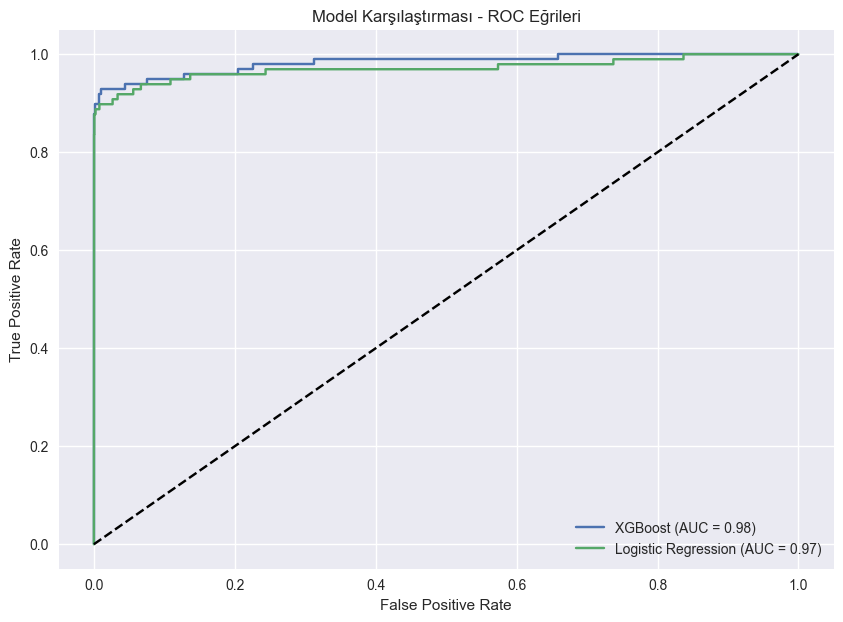

In [5]:
# Karşılaştırma Tablosu
metrics = {
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, xgb_preds),
        'Precision': precision_score(y_test, xgb_preds),
        'Recall': recall_score(y_test, xgb_preds),
        'F1': f1_score(y_test, xgb_preds),
        'ROC AUC': roc_auc_score(y_test, xgb_probs),
        'Avg Precision': average_precision_score(y_test, xgb_probs)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_preds),
        'Precision': precision_score(y_test, lr_preds),
        'Recall': recall_score(y_test, lr_preds),
        'F1': f1_score(y_test, lr_preds),
        'ROC AUC': roc_auc_score(y_test, lr_probs),
        'Avg Precision': average_precision_score(y_test, lr_probs)
    }
}

# DataFrame'e çevir ve kaydet
metrics_df = pd.DataFrame(metrics).T

# Metrics klasörünü oluştur
metrics_dir = REPORTS_DIR / 'metrics'
os.makedirs(metrics_dir, exist_ok=True)

# CSV olarak kaydet - artık doğru yol kullanılıyor
metrics_path = metrics_dir / f'model_metrics_{VERSION}.csv'
metrics_df.to_csv(metrics_path)
print(f"⭐ Model Karşılaştırması (CSV olarak kaydedildi: {metrics_path})")
display(metrics_df.style.background_gradient(cmap='Blues'))

# ROC Eğrilerini Karşılaştır
plt.figure(figsize=(10, 7))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Karşılaştırması - ROC Eğrileri')
plt.legend()
plt.grid(True)

# Karşılaştırma grafiğini kaydet
save_figure(plt.gcf(), 'model_comparison_roc.png', version=VERSION, reports_dir=REPORTS_DIR)


✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\xgboost_threshold_optimization.png


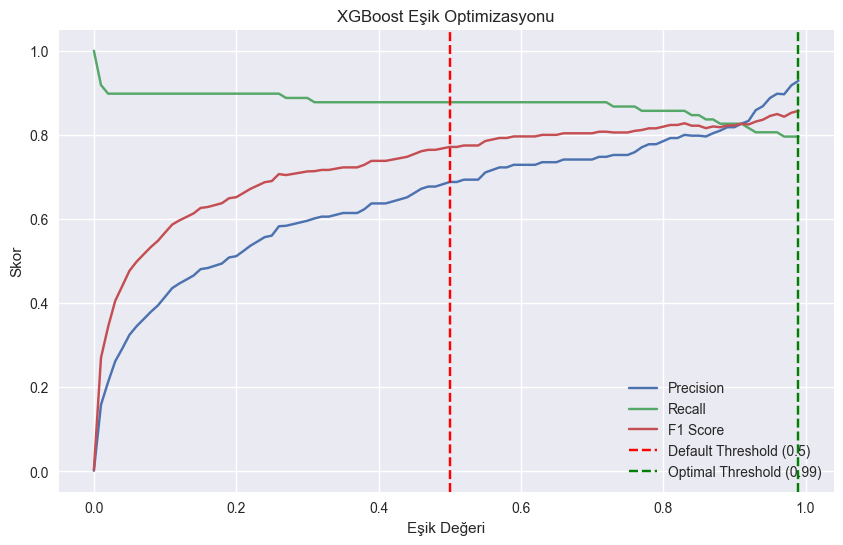

XGBoost Optimal Eşik: 0.990, F1 Skoru: 0.857
✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\lr_threshold_optimization.png


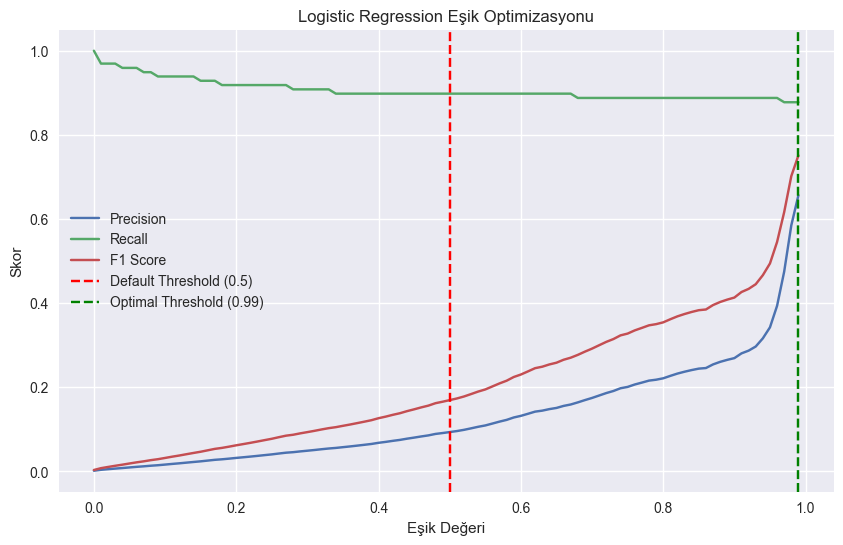

Logistic Regression Optimal Eşik: 0.990, F1 Skoru: 0.751


In [6]:
# Hücre 6: Eşik Değeri Optimizasyonu
fig_thresh_xgb, opt_thresh_xgb, best_f1_xgb = plot_threshold_optimization(
    y_test, xgb_probs, title='XGBoost Eşik Optimizasyonu'
)
save_figure(fig_thresh_xgb, 'xgboost_threshold_optimization.png', version=VERSION, reports_dir=REPORTS_DIR)
print(f"XGBoost Optimal Eşik: {opt_thresh_xgb:.3f}, F1 Skoru: {best_f1_xgb:.3f}")

fig_thresh_lr, opt_thresh_lr, best_f1_lr = plot_threshold_optimization(
    y_test, lr_probs, title='Logistic Regression Eşik Optimizasyonu'
)
save_figure(fig_thresh_lr, 'lr_threshold_optimization.png', version=VERSION, reports_dir=REPORTS_DIR)
print(f"Logistic Regression Optimal Eşik: {opt_thresh_lr:.3f}, F1 Skoru: {best_f1_lr:.3f}")

C:\Users\PC\Desktop\fraud_eye\src\utils\visualizations.py:550: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\xgboost_metrics_dashboard.png


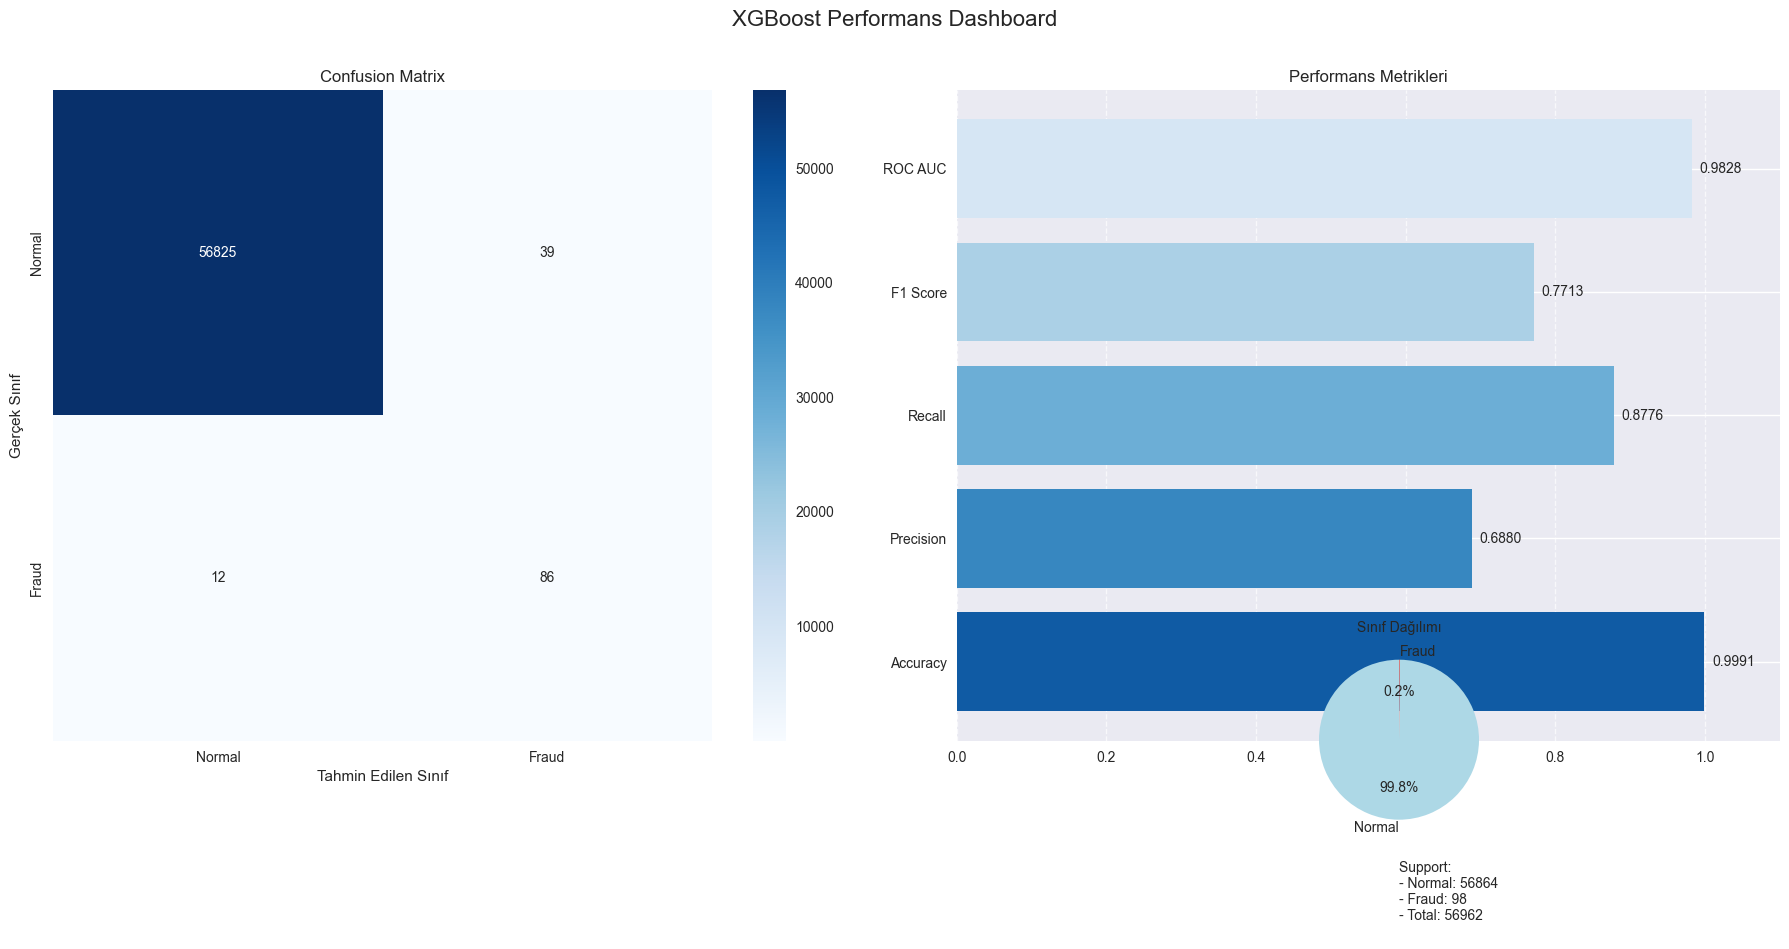

C:\Users\PC\Desktop\fraud_eye\src\utils\visualizations.py:550: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\logistic_metrics_dashboard.png


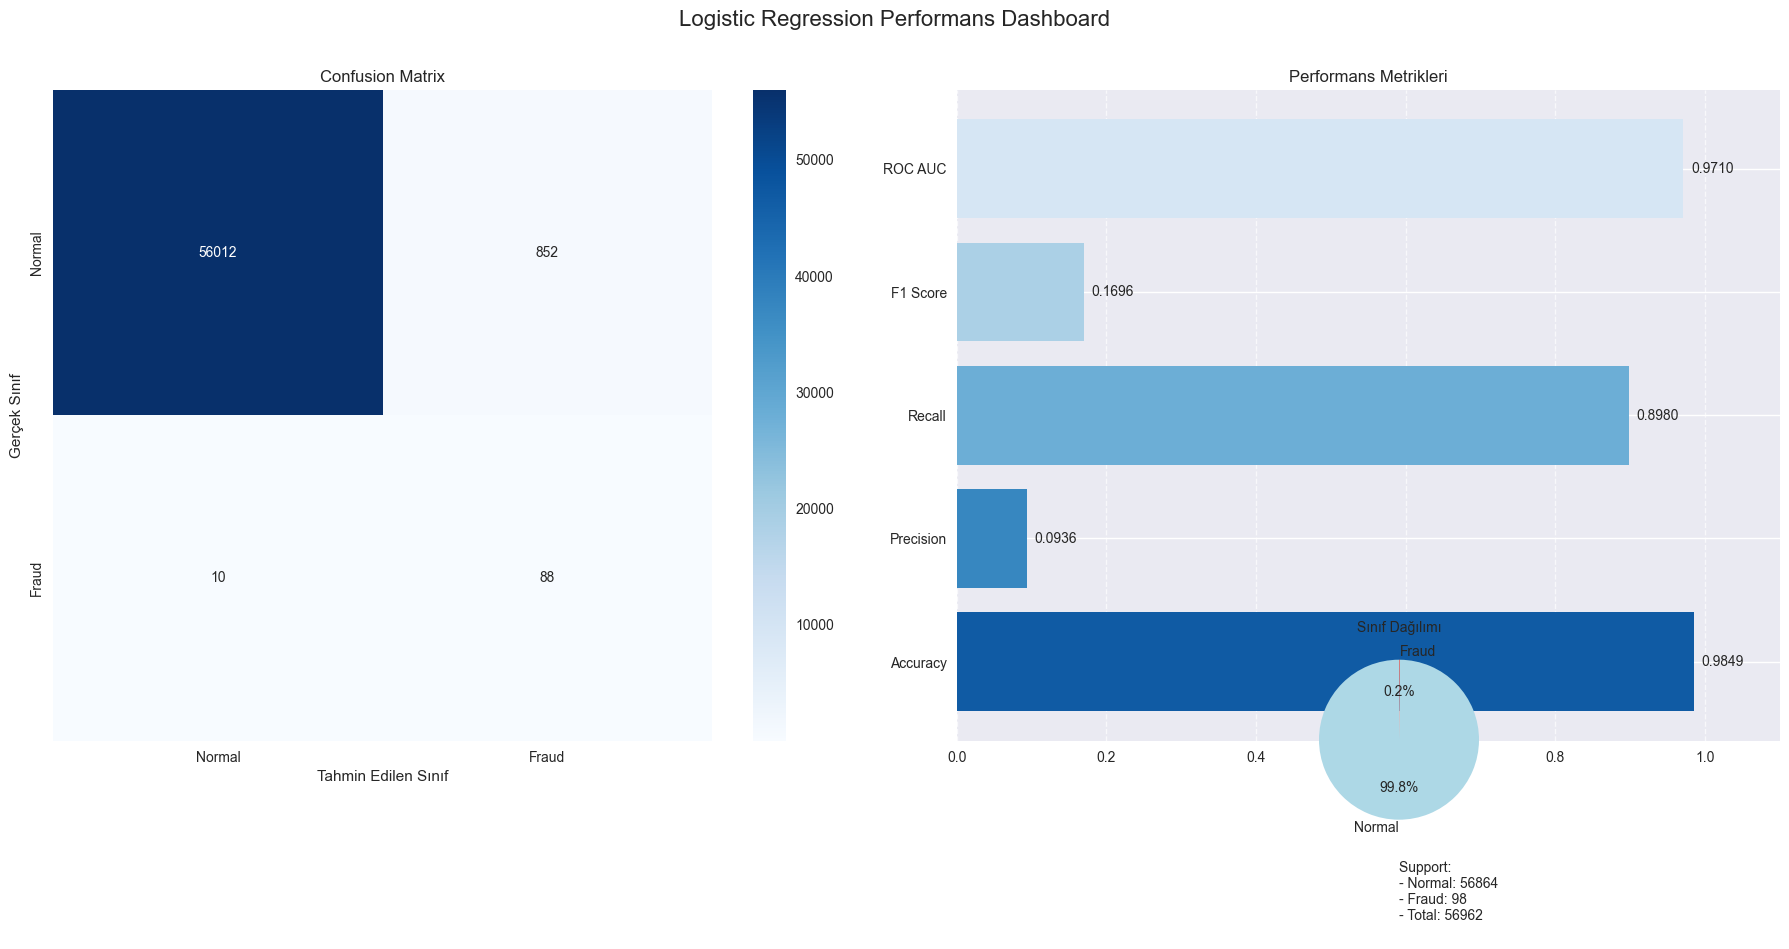

✔ Görsel kaydedildi: C:\Users\PC\Desktop\fraud_eye\reports\figures\V1\models_comparison_dashboard.png


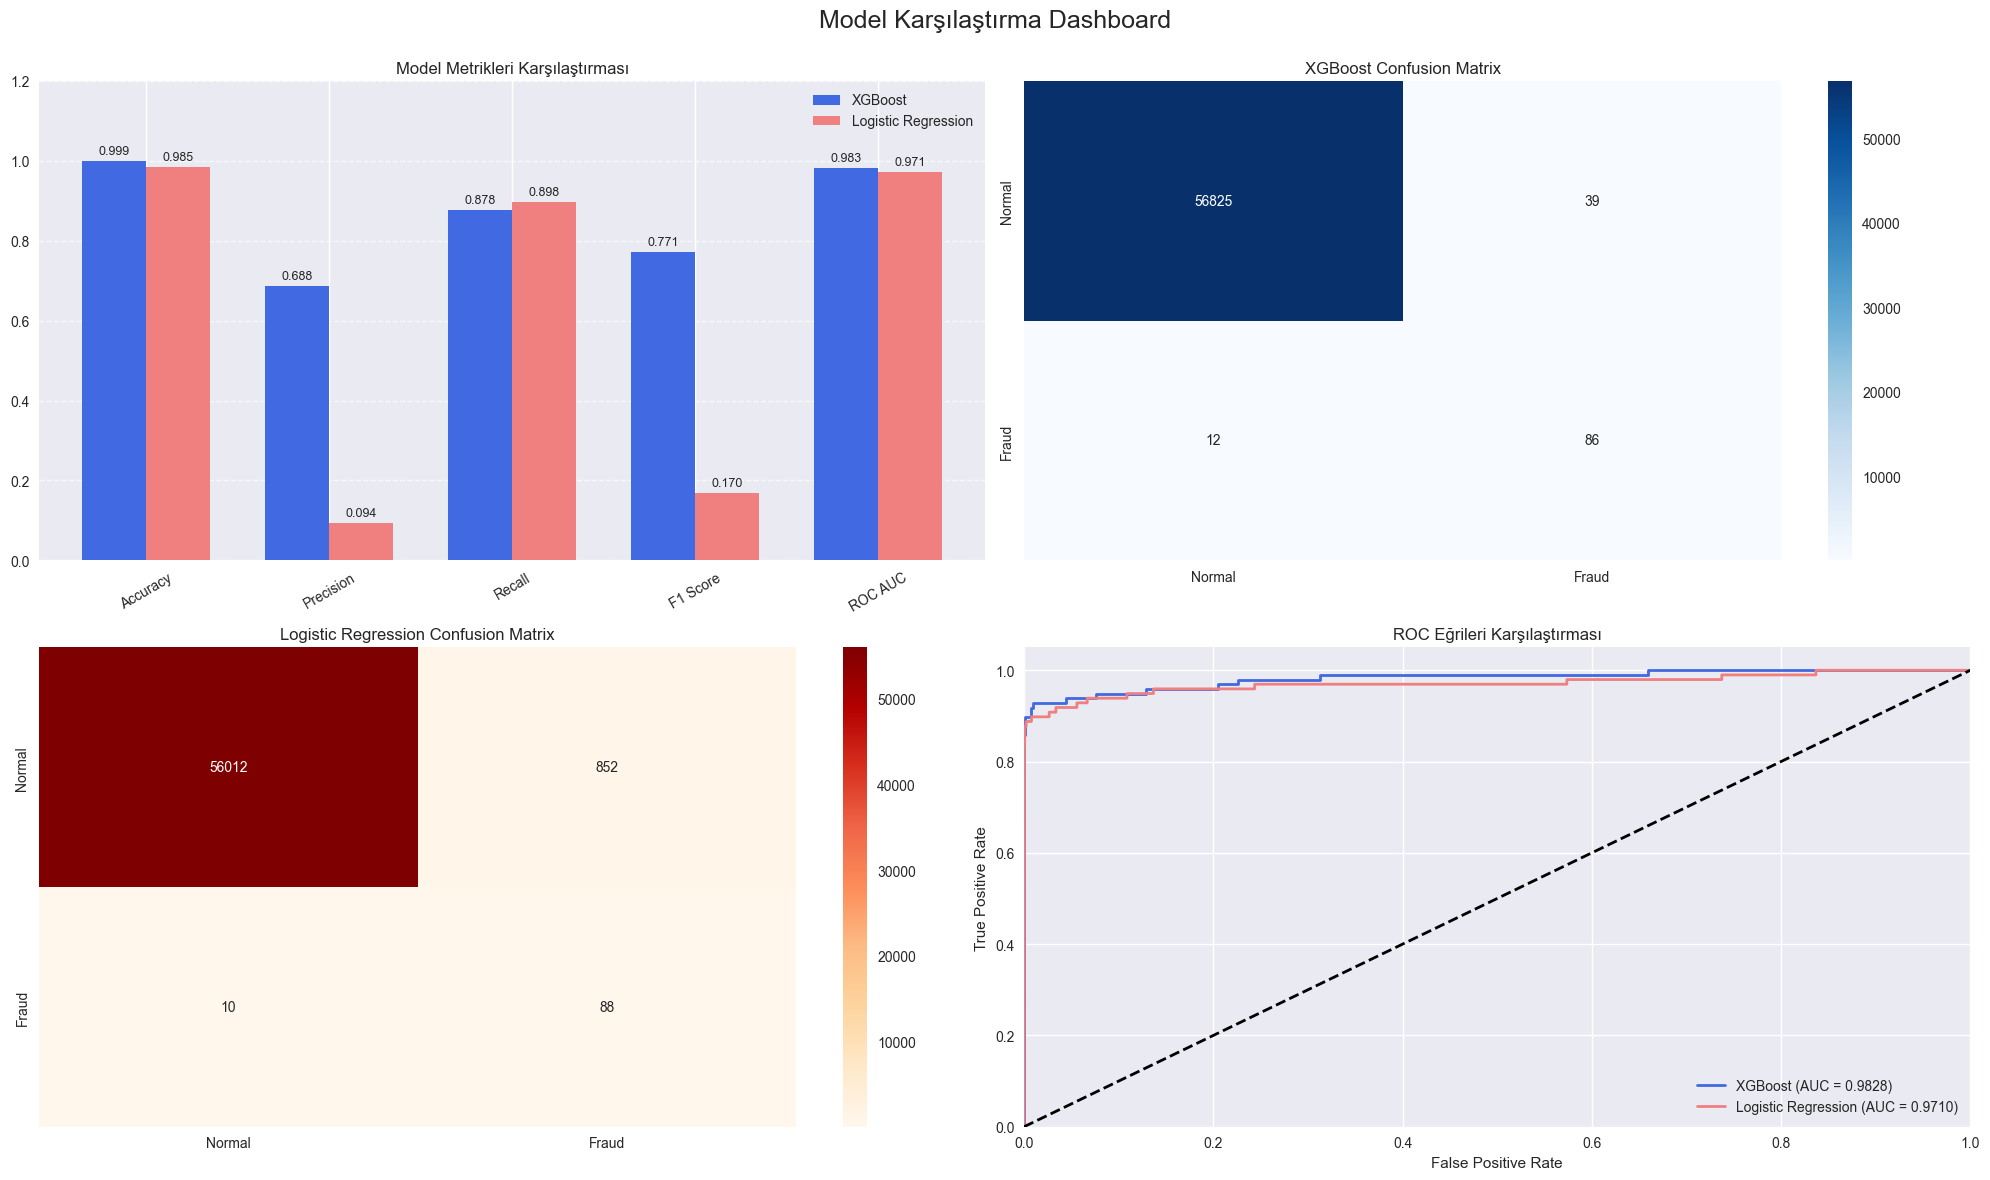

✅ Geliştirilmiş performans görselleştirmeleri tamamlandı ve kaydedildi!


In [7]:
# Hücre 7: Geliştirilmiş Metrik ve Confusion Matrix Görselleştirmesi
# XGBoost için performans görselleştirmesi
fig_metrics_xgb = plot_metrics_with_confusion_matrix(
    y_test, xgb_preds, y_proba=xgb_probs,
    title='XGBoost Performans Dashboard'
)
save_figure(fig_metrics_xgb, 'xgboost_metrics_dashboard.png', version=VERSION, reports_dir=REPORTS_DIR)

# Logistic Regression için performans görselleştirmesi
fig_metrics_lr = plot_metrics_with_confusion_matrix(
    y_test, lr_preds, y_proba=lr_probs,
    title='Logistic Regression Performans Dashboard'
)
save_figure(fig_metrics_lr, 'logistic_metrics_dashboard.png', version=VERSION, reports_dir=REPORTS_DIR)

# Model karşılaştırması için dashboard görselleştirmesi
models_data = {
    'XGBoost': (xgb_preds, xgb_probs),
    'Logistic Regression': (lr_preds, lr_probs)
}

fig_comparison = plot_models_comparison_dashboard(y_test, models_data)
save_figure(fig_comparison, 'models_comparison_dashboard.png', version=VERSION, reports_dir=REPORTS_DIR)

print("✅ Geliştirilmiş performans görselleştirmeleri tamamlandı ve kaydedildi!")